In [37]:
#!/usr/bin/env python3

import os, sys
sys.path.append('../')
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

from triggers_helper import CalRatioHighET_L1,CalRatioLowET_L1
import sys
sys.path.append('../')

try:
    import mplhep as hep
    hep.style.use("ATLAS")
except:
    pass
delphesDir = os.path.abspath("../DelphesLLP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')



True

In [2]:
inputFile = '../ddmH_mS_500_m1_244_dm_90_nosmear.root'
# inputFile = '../DelphesLLP/test.root'

In [24]:
f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")

c_light = 2.99792458e8

nevts = tree.GetEntries()
rDecays = []
for ievt in range(nevts):
    tree.GetEntry(ievt)
    event = {
            'jetsL1' : tree.L1SmallJetOnTime, 
            'jetsHLT' : tree.HLTJetOnTime
            }  

    l1_cutflow = CalRatioLowET_L1(event['jetsL1'])
    # If failed, check high ET trigger
    if any(val == 0 for val in l1_cutflow.values()):
        l1_cutflow = CalRatioHighET_L1(event['jetsL1'],pTmin = 60.0)
    l1_pass = all(val != 0 for val in l1_cutflow.values())
    if not l1_pass:
        continue

    # Get parton level MET and b-bar angular separation
    llps = list(tree.llpParticles)
    llpDec = {}
    for d in tree.llpDirectDaughters:
        illp = d.M1
        x = np.array([d.X,d.Y,d.Z,d.T])
        l = np.linalg.norm(x[:3])*1e-3
        t_readout = x[-1]-l/c_light
        # # Select only decays on the N-1 event
        # if t_readout > 10e-9:
        #     continue
        x[-1] = t_readout
        llpDec[illp] = x
    decs = sorted(llpDec.values(), key = lambda d : d[-1])
    rDecays.append(decs)
f.Close()

In [25]:
rDecays = np.array(rDecays)

In [26]:
rDecays.shape

(12591, 2, 4)

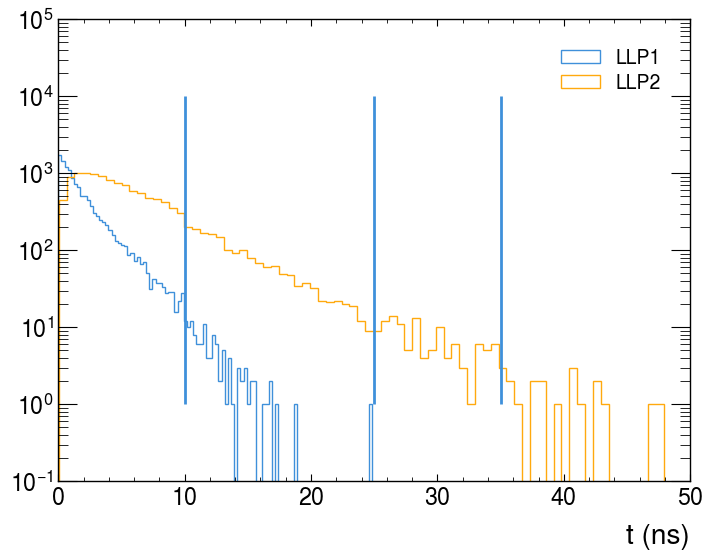

In [27]:
plt.hist(rDecays[:,0,-1]*1e9,bins=100,label='LLP1',histtype='step')
plt.hist(rDecays[:,1,-1]*1e9,bins=100,label='LLP2',histtype='step')
plt.vlines(x = [10,25,35],ymin=1,ymax=1e4)

plt.yscale('log')
plt.legend()
plt.xlabel('t (ns)')
plt.xlim(0,50)
plt.show()

In [30]:
nHCAL = 0
nNm1 = 0
for dec1,dec2 in rDecays:
    hlt_pass =False
    if dec1[-1] < 10e-9:
        r1 = np.linalg.norm(dec1[:2])*1e-3
        z1 = np.abs(dec1[2])*1e-3
        if 2.0 < r1 < 3.5 and z1 < 5.5:
            hlt_pass = True
    
    if not hlt_pass and dec2[-1] < 10e-9:
        r2 = np.linalg.norm(dec2[:2])*1e-3
        z2 = np.abs(dec2[2])*1e-3
        if 2.0 < r2 < 3.5 and z2 < 5.5:
            hlt_pass = True
    
    if hlt_pass: nHCAL += 1
print(nHCAL)

2531


In [19]:
rDecay1_ontime = rDecay1[rDecay1[:,-1] < 10e-9]
rDecay2_ontime = rDecay2[rDecay2[:,-1] < 10e-9]

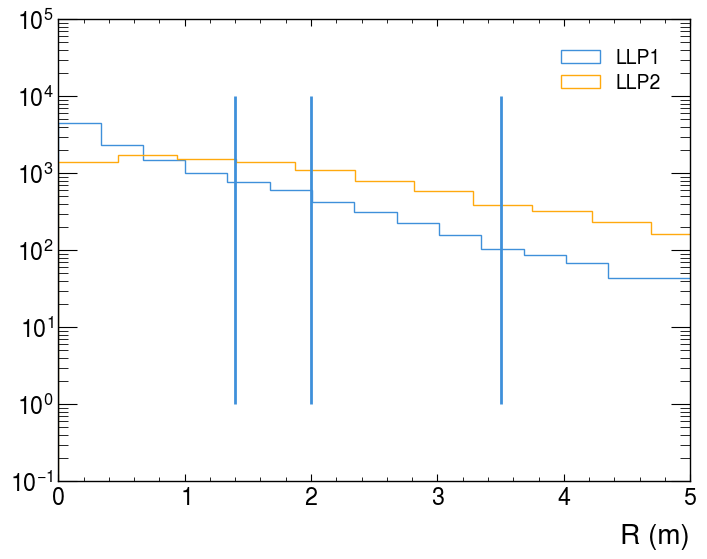

In [20]:
rho1 = np.sqrt(rDecay1_ontime[:,0]**2 + rDecay1_ontime[:,1]**2)/1e3
rho2 = np.sqrt(rDecay2_ontime[:,0]**2 + rDecay2_ontime[:,1]**2)/1e3
plt.hist(rho1,bins=100,label='LLP1',histtype='step')
plt.hist(rho2,bins=100,label='LLP2',histtype='step')
plt.vlines(x = [1.4,2.0,3.5],ymin=1,ymax=1e4)

plt.yscale('log')
plt.legend()
plt.xlabel('R (m)')
plt.xlim(0,5)
plt.show()

In [31]:
pts = []
for _,dec2 in rDecays:
    r2 = np.linalg.norm(dec2[:2])*1e-3
    z2 = dec2[2]*1e-3
    pts.append([r2,z2,dec2[-1]])

pts = np.array(pts)

In [32]:
pts_ontime = pts[pts[:,-1] < 10e-9]

In [48]:
len(pts_ontime)

10704

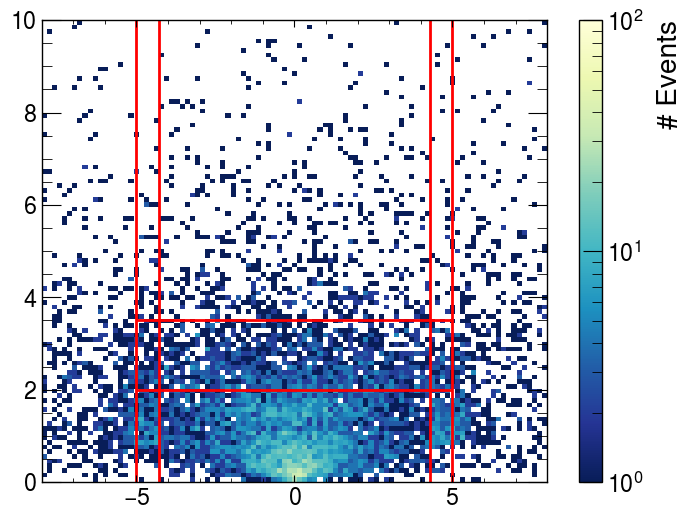

In [57]:
plt.hist2d(pts_ontime[:,1],pts_ontime[:,0],
           bins=[np.linspace(-8,8,100),np.linspace(0.,10.,100)],
           cmap = mpl.colormaps['YlGnBu_r'], norm = mpl.colors.LogNorm(vmin=1.0,vmax=100.))
plt.vlines(x=[4.3,5.0],ymin=0.,ymax=10.,colors='red')
plt.vlines(x=[-4.3,-5.0],ymin=0.,ymax=10.,colors='red')
plt.hlines(y=[2.0,3.5],xmin=-5.0,xmax=5.0,colors='red')
plt.colorbar(label='# Events')
plt.show()

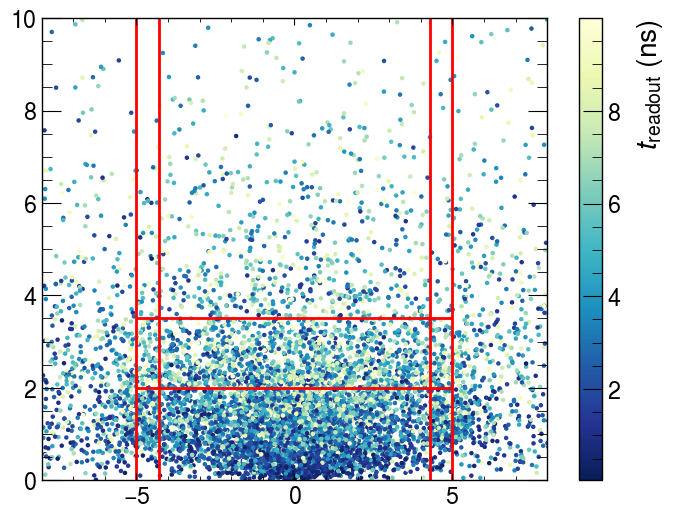

In [56]:
plt.scatter(pts_ontime[:,1],pts_ontime[:,0],c=(1e9*pts_ontime[:,-1]),
           cmap = mpl.colormaps['YlGnBu_r'],s=5)
plt.vlines(x=[4.3,5.0],ymin=0.,ymax=10.,colors='red')
plt.vlines(x=[-4.3,-5.0],ymin=0.,ymax=10.,colors='red')
plt.hlines(y=[2.0,3.5],xmin=-5.0,xmax=5.0,colors='red')
plt.colorbar(label=r'$t_{\rm readout}$ (ns)')
plt.xlim(-8,8)
plt.ylim(0.,10)
plt.show()